# Olist 데이터셋 품질 분석 (EDA 자동화)

**분석 내용:**
1. 테이블별 결측치(Missing Values) 확인
2. 수치형 컬럼 기술통계(Descriptive Statistics) 출력
3. 이상치(Outliers) 식별을 위한 Boxplot 시각화

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# 프로젝트 루트 경로 추가
sys.path.append(os.path.abspath('..'))

from src.data_loader import load_all_tables
from src.utils import set_korean_font

# 시각화 설정
set_korean_font()
plt.style.use('seaborn-v0_8-whitegrid')

# 데이터 로드
tables = load_all_tables(verbose=False)
print("✅ 데이터 로딩 완료")

✅ 한글 폰트 설정 완료 (Windows)
✅ 데이터 로딩 완료


### 1.  각 테이블을 개별 변수 이름에 저장

In [99]:
# [추가] 각 테이블을 개별 변수에 저장
customers = tables['customers']
geolocation = tables['geolocation']
order_items = tables['order_items']
order_payments = tables['order_payments']
order_reviews = tables['order_reviews']
orders = tables['orders']
products = tables['products']
sellers = tables['sellers']

print("✅ 변수 할당 완료: customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers")

✅ 변수 할당 완료: customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers


## ✅ products 테이블 전처리
- products 테이블 내 전체 product_id 는 판매가 "이루어진" 상품
- 결측치 (카테고리 네임 NaN) 610개 NaN -> "unknown"으로 대체
- 나머지 메타데이터(상품설명) 컬럼 -> 0으로 치환
- 규격정보(무게 길이 등)2개 -> 중앙값으로 대체

In [100]:
# 1. 판매된 적 있는 유니크한 상품 리스트 (order_items 기준)
sold_product_ids = set(order_items['product_id'].unique())

# 2. 전체 등록된 상품 리스트 (products 기준)
all_product_ids = set(products['product_id'].unique())

# 3. 등록은 되었으나 한 번도 팔리지 않은 상품 찾기
unsold_products = all_product_ids - sold_product_ids

print(f"📦 전체 등록 상품 수: {len(all_product_ids):,d}개")
print(f"💰 판매 이력이 있는 상품 수: {len(sold_product_ids):,d}개")
print(f"👻 등록 후 한 번도 팔리지 않은 상품 수: {len(unsold_products):,d}개")

📦 전체 등록 상품 수: 32,951개
💰 판매 이력이 있는 상품 수: 32,951개
👻 등록 후 한 번도 팔리지 않은 상품 수: 0개


In [101]:
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [102]:
# 결측치 처리
products['product_category_name'].fillna('unknown', inplace=True)
products['product_name_lenght'].fillna(0, inplace=True)
products['product_description_lenght'].fillna(0, inplace=True)
products['product_photos_qty'].fillna(0, inplace=True)
products['product_weight_g'].fillna(products['product_weight_g'].median(), inplace=True)
products['product_length_cm'].fillna(products['product_length_cm'].median(), inplace=True)
products['product_height_cm'].fillna(products['product_height_cm'].median(), inplace=True)
products['product_width_cm'].fillna(products['product_width_cm'].median(), inplace=True)

In [103]:
clean_products = products.copy()

In [ ]:
# 결측치 재 확인
clean_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## ✅ orders 테이블 전처리
- orders 테이블 내, 주문상태가 'delivered'가 아닌 주문은 제거(주문취소, 배송지연 등은 분석에서 제외)
- orders_status가 'delivered'이나, 주문승인시간, 판매자 배송완료 시간, 고객 도착 시간이 null인 주문은 제거
- 파생변수 boxplot 확인결과, 음수 값 존재하여 음수값 제거
- 추후, 취소된 배송 건에 대한 사유 별도 분석 필요

### 📊 생성된 파생변수 명세서 (최종 업데이트)

| 파생변수명 | 의미 | 계산 로직 / 추출 방식 | 비즈니스 관점 |
| :--- | :--- | :--- | :--- |
| `total_delivery_time` | **총 배송 시간** | [(도착일 - 주문일).dt.days] | 전체 고객 경험 및 플랫폼 만족도 측정 |
| `seller_prep_time` | **판매자 준비 시간** | [(물류사 인계일 - 결제 승인일).dt.days] | 판매자(Seller)의 운영 효율성 및 성과 평가 |
| `pure_shipping_time` | **순수 운송 시간** | [(도착일 - 물류사 인계일).dt.days] | 물류사(Carrier)의 배송 성능 및 구간 효율 측정 |
| `delivery_accuracy` | **배송 정확도** | [(배송 예정일 - 실제 도착일).dt.days] | 고객과의 약속 이행도 및 서비스 신뢰도 파악 |
| `estimated_wait_time` | **예상 대기 시간** | [(배송 예정일 - 주문일).dt.days] | 구매 결정 시 고객이 수용한 배송 기대 수치 |
| `is_delayed` | **지연 여부** | `실제 도착일 > 배송 예정일` (지연 시 1) | 불만 고객 타겟팅 및 플랫폼 경쟁력 저해 요인 파악 |
| `delivery_speed_type` | **배송 속도 범주** | `pd.cut` (Very Fast, Normal, Slow, Very Slow) | 배송 성과별 세그먼트 분류 및 핵심 관리 대상 식별 |
| `purchase_hour` | **주문 시간대** | `order_purchase_timestamp.dt.hour` | 피크 타임 파악 및 타겟 마케팅 전략 수립 |
| `purchase_dayofweek` | **주문 요일** | `order_purchase_timestamp.dt.day_name()` | 요일별 구매 패턴 및 물류 부하량 예측 |
| `purchase_month` | **주문 월** | `order_purchase_timestamp.dt.month` | 월별 매출 트렌드 분석 및 계절성 파악 |
| `is_weekend` | **주말 여부** | `order_purchase_timestamp.dt.weekday >= 5` | 평일/주말 쇼핑 라이프스타일 비교 분석 |

In [105]:
# 기본 정보 확인
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [106]:
# 결측치 확인
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
orders = orders[orders['order_status'] == 'delivered'].copy()

In [110]:
orders.dropna(inplace=True)
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [113]:
# 1. 날짜로 변환할 컬럼 리스트 정의
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
# 2. 반복문을 사용하여 각 컬럼을 datetime 형식으로 변환
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])
# 3. 변환 결과 확인 (dtype이 datetime64로 바뀌었는지 확인)
print(orders[date_columns].dtypes)

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [114]:
# 주문 상태 범주 확인
orders['order_status'].value_counts()

order_status
delivered    96455
Name: count, dtype: int64

In [116]:
# 1. 시계열 기반 파생변수 생성 (성능 및 대기 관점)
# 총 배송 시간 (주문 ~ 수령)
orders['total_delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
# 판매자 준비 시간 (승인 ~ 물류사 인계)
orders['seller_prep_time'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days
# 순수 운송 시간 (물류사 인계 ~ 수령)
orders['pure_shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days
# 배송 정확도 (예정일 - 실제수령일) : 양수면 조기, 음수는 지연
orders['delivery_accuracy'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days
# 심리적 예상 대기 시간 (예정일 - 주문일)
orders['estimated_wait_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days
# 지연 여부 (지연이면 1, 아니면 0)
orders['is_delayed'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)
# 2. 시간대/요일 파생변수 생성 (고객 행동 관점)
orders['purchase_hour'] = orders['order_purchase_timestamp'].dt.hour
orders['purchase_dayofweek'] = orders['order_purchase_timestamp'].dt.day_name()
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['is_weekend'] = orders['order_purchase_timestamp'].dt.weekday >= 5
# 3. 배송 속도 범주화를 위한 기술통계 확인
print("📊 [Total Delivery Time] Descriptive Statistics")
display(orders['total_delivery_time'].describe())

📊 [Total Delivery Time] Descriptive Statistics


count    96455.000000
mean        12.093100
std          9.551209
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: total_delivery_time, dtype: float64

In [117]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96455 entries, 0 to 99440
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96455 non-null  object        
 1   customer_id                    96455 non-null  object        
 2   order_status                   96455 non-null  object        
 3   order_purchase_timestamp       96455 non-null  datetime64[ns]
 4   order_approved_at              96455 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96455 non-null  datetime64[ns]
 6   order_delivered_customer_date  96455 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96455 non-null  datetime64[ns]
 8   total_delivery_time            96455 non-null  int64         
 9   seller_prep_time               96455 non-null  int64         
 10  pure_shipping_time             96455 non-null  int64         
 11  delivery_accuracy   

In [119]:
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
total_delivery_time              0
seller_prep_time                 0
pure_shipping_time               0
delivery_accuracy                0
estimated_wait_time              0
is_delayed                       0
purchase_hour                    0
purchase_dayofweek               0
purchase_month                   0
is_weekend                       0
dtype: int64

📊 배송 속도별 주문 비중
delivery_speed_type
Very Fast    27.002229
Normal       48.941994
Slow         19.788502
Very Slow     4.267275
Name: proportion, dtype: float64


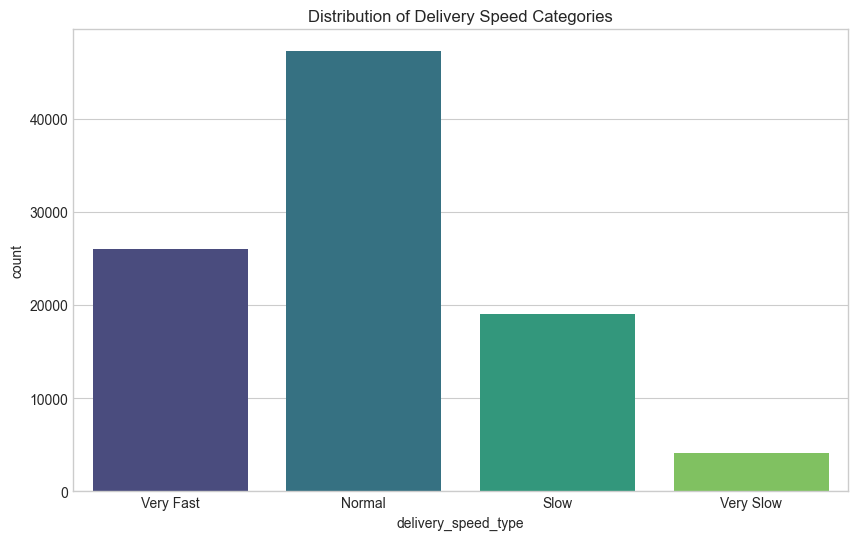

In [123]:
# 구간 경계 설정 (0, 6, 15, 30, 최대값)
bins = [-1, 6, 15, 30, orders['total_delivery_time'].max()]
labels = ['Very Fast', 'Normal', 'Slow', 'Very Slow']

# 배송 속도 범주화 컬럼 생성
orders['delivery_speed_type'] = pd.cut(orders['total_delivery_time'], bins=bins, labels=labels)

# 결과 확인 (범주별 비중)
print("📊 배송 속도별 주문 비중")
print(orders['delivery_speed_type'].value_counts(normalize=True).sort_index() * 100)

# 시각화 (Countplot)
plt.figure(figsize=(10, 6))
sns.countplot(data=orders, x='delivery_speed_type', palette='viridis')
plt.title('Distribution of Delivery Speed Categories')
plt.show()

In [124]:
# 1. 음수 데이터(논리적 오류) 식별을 위한 조건 설정
# 총 배송 시간, 판매자 준비 시간, 순수 운송 시간은 0보다 작을 수 없습니다.
mask_logical_error = (orders['total_delivery_time'] < 0) | \
                     (orders['seller_prep_time'] < 0) | \
                     (orders['pure_shipping_time'] < 0)

# 2. 오류 데이터 개수 확인
error_count = mask_logical_error.sum()
print(f"🚩 제거할 음수 데이터 건수: {error_count}건")

# 3. 음수 데이터 제외 및 데이터프레임 갱신
# (원본을 보존하고 싶다면 orders_cleaned = orders[~mask_logical_error].copy() 사용)
orders = orders[~mask_logical_error].copy()

print(f"✅ 필터링 완료. 현재 남은 데이터 건수: {len(orders):,d}건")

🚩 제거할 음수 데이터 건수: 1373건
✅ 필터링 완료. 현재 남은 데이터 건수: 95,082건


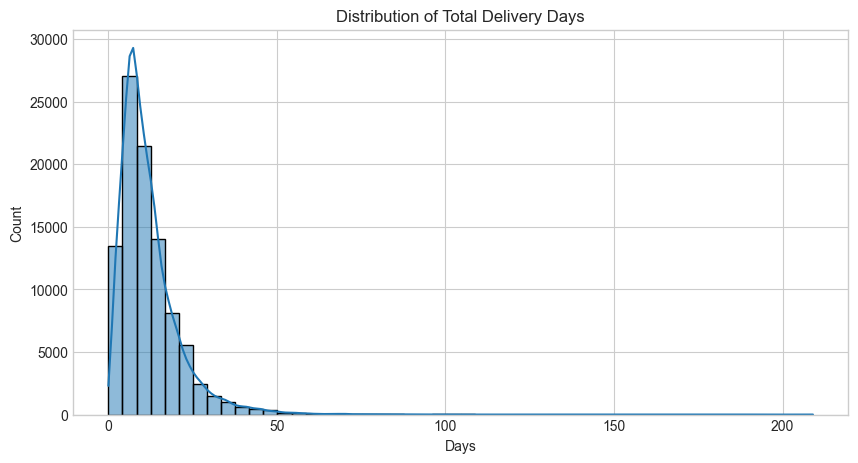

In [118]:
# 시각적으로 분포 확인 (이상치 제외하고 30일 이내 분포 위주)
plt.figure(figsize=(10, 5))
sns.histplot(orders['total_delivery_time'].dropna(), bins=50, kde=True)
plt.title('Distribution of Total Delivery Days')
plt.xlabel('Days')
plt.show()

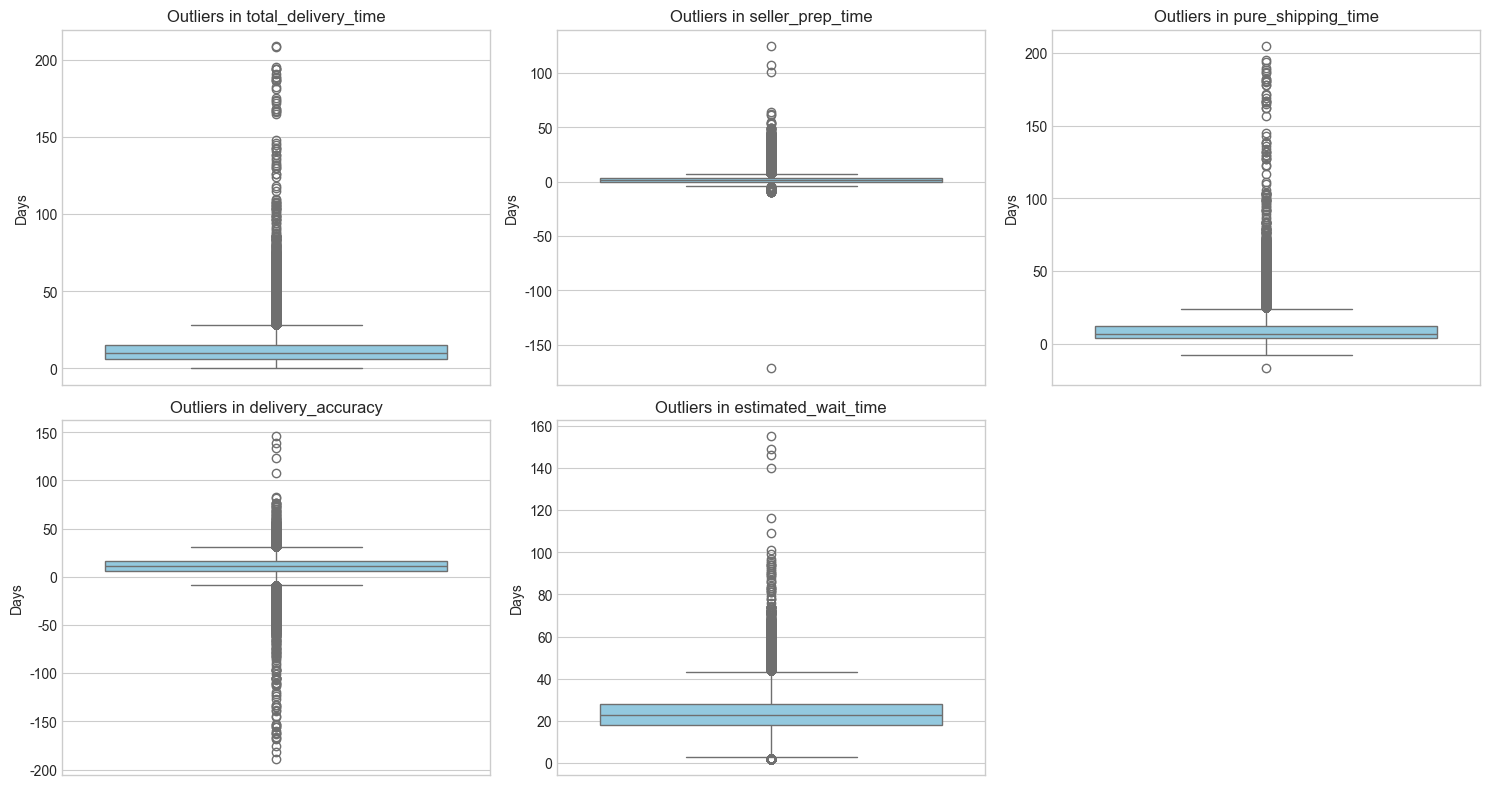

📌 주요 파생변수의 상위 1% (그 이상의 값은 극단적 이상치 가능성)


total_delivery_time    46.0
seller_prep_time       17.0
pure_shipping_time     40.0
delivery_accuracy      35.0
estimated_wait_time    50.0
Name: 0.99, dtype: float64

In [120]:
# 1. 시각화할 수치형 파생변수 리스트 선정
# (날짜와 요일 등 범주형 성격 리스트는 제외)
numeric_derived_cols = [
    'total_delivery_time', 
    'seller_prep_time', 
    'pure_shipping_time', 
    'delivery_accuracy', 
    'estimated_wait_time'
]

# 2. 그래프 레이아웃 설정
plt.figure(figsize=(15, 8))

# 3. 반복문을 이용해 각 컬럼의 Boxplot 출력
for i, col in enumerate(numeric_derived_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=orders[col].dropna(), color='skyblue')
    plt.title(f'Outliers in {col}')
    plt.ylabel('Days')

plt.tight_layout()
plt.show()

# 4. (참고) 이상치 값을 요약해서 출력하기 (상위 99% 컷오프 지점 확인)
print("📌 주요 파생변수의 상위 1% (그 이상의 값은 극단적 이상치 가능성)")
display(orders[numeric_derived_cols].quantile(0.99))

In [46]:
orders['estimated_wait_time'].describe()

count    99441.000000
mean        23.403958
std          8.829562
min          1.000000
25%         18.000000
50%         23.000000
75%         28.000000
max        155.000000
Name: estimated_wait_time, dtype: float64

In [145]:
clean_orders = orders.copy()

## ✅ orders_payments 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [130]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [131]:
order_payments.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [134]:
order_payments[order_payments['payment_sequential'] > 1]['payment_type'].value_counts()

payment_type
voucher        4154
credit_card     319
debit_card       52
boleto            1
Name: count, dtype: int64

In [ ]:
# 1. 결제 순번이 가장 높은(29) 주문의 order_id 찾기
max_seq_order = order_payments[order_payments['payment_sequential'] == 29]['order_id'].values[0]

# 2. 해당 주문의 전체 결제 내역 확인
target_order_payments = order_payments[order_payments['order_id'] == max_seq_order].sort_values('payment_sequential')

print(f"🚩 29번 분할 결제된 주문 ID: {max_seq_order}")
display(target_order_payments)

In [144]:
clean_order_paymets = order_payments.copy()

## ✅ sellers 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [146]:
clean_sellers = sellers.copy()

## ✅ order_items 테이블 전처리
- order_item_id : 1번 주문에 몇개의 상품을 주문하였는지
- shipping_limit_date : 판매자 -> 물류센터 배송 마감 기한
- 별도 결측치 및 이상치 없음으로 종결

In [137]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [138]:
order_items.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

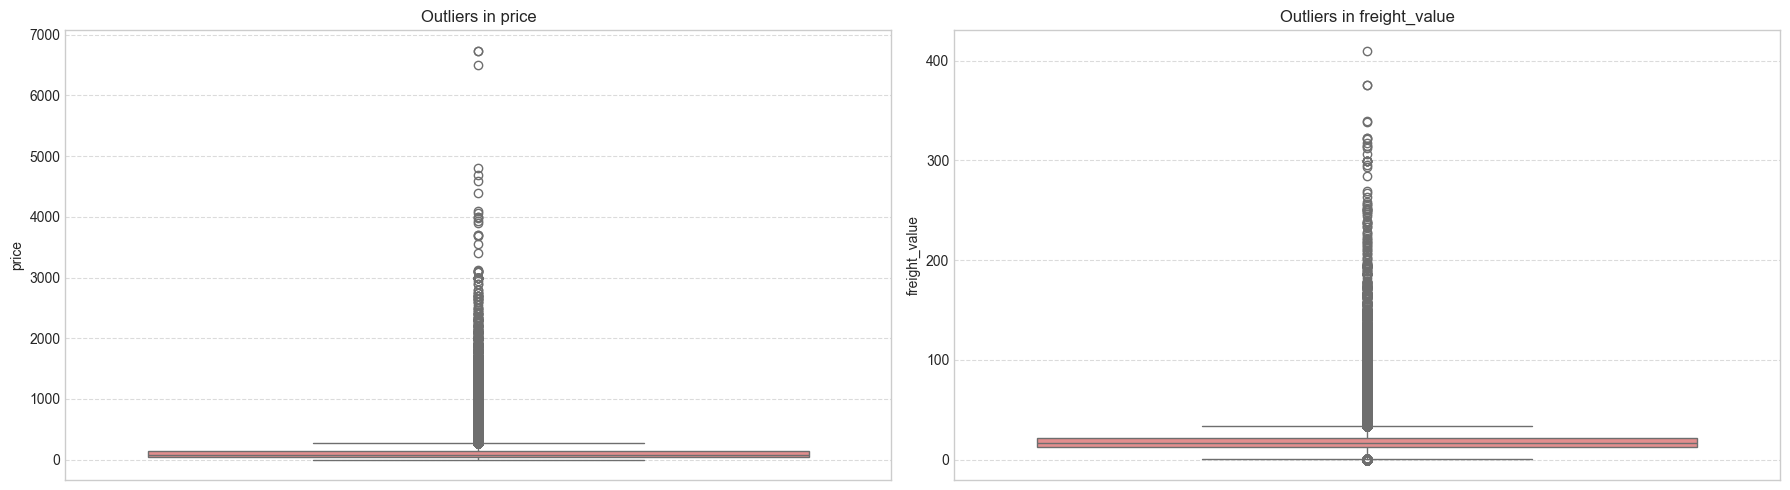

📌 결제 관련 변수들의 상위 1% 임계치:


price            890.00
freight_value     84.52
Name: 0.99, dtype: float64

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 시각화할 수치형 컬럼 리스트
payment_cols = ['price', 'freight_value']

# 2. 그래프 레이아웃 설정 (1행 3열)
plt.figure(figsize=(18, 5))

# 3. 반복문을 이용한 Boxplot 출력
for i, col in enumerate(payment_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(y=order_items[col], color='lightcoral')
    plt.title(f'Outliers in {col}', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. 수치상으로도 이상치 확인 (상위 99% 값)
print("📌 결제 관련 변수들의 상위 1% 임계치:")
display(order_items[payment_cols].quantile(0.99))

In [140]:
# 1. 주문별 아이템 총액(가격 + 배송비) 계산
items_total = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
items_total['items_total_sum'] = items_total['price'] + items_total['freight_value']

# 2. 주문별 실제 결제 총액 합산
payments_total = order_payments.groupby('order_id')['payment_value'].sum().reset_index()

# 3. 두 데이터 병합
validation_df = pd.merge(items_total, payments_total, on='order_id')

# 4. 차액 계산 (소수점 오차 고려)
validation_df['diff'] = validation_df['items_total_sum'] - validation_df['payment_value']

# 5. 결과 확인 (차액이 거의 0인 행의 비율 확인)
accurate_match = validation_df[abs(validation_df['diff']) < 0.1]
print(f"✅ 금액이 일치하는 주문 비율: {(len(accurate_match) / len(validation_df)) * 100:.2f}%")

# 차이가 나는 케이스가 있다면 확인 (보통 바우처나 반올림 이슈)
display(validation_df[abs(validation_df['diff']) >= 0.1].head())

✅ 금액이 일치하는 주문 비율: 99.74%


order_id   price  freight_value  \
165   00789ce015e7e5791c7914f32bb4fad4  154.00          14.83   
525   016726239765c18f66826453f39c64e3  219.99          15.14   
724   01e51b7c3025655646143d09b911e1d7   19.00          14.10   
965   028aa7c930356788f861ed1b7f984819   39.90          17.63   
1123  02f4dd90ba0feb8ec394cac05862d2b5   79.90          51.06   

      items_total_sum  payment_value   diff  
165            168.83         190.81 -21.98  
525            235.13         265.77 -30.64  
724             33.10          35.02  -1.92  
965             57.53          62.94  -5.41  
1123           130.96         141.65 -10.69

In [147]:
clean_order_items = order_items.copy()

## ✅ order_customers 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [150]:
clean_order_customers = customers.copy()

## ✅ order_reviews 테이블 전처리
- 별도 이상치 없음 으로 종결
- 결측치 코멘트 및 제목 수용

In [152]:
clean_order_reviews = order_reviews.copy()

## ✅ geolocation 테이블 전처리
- 별도 이상치 없음 으로 종결

    - 결론적으로
    주 이름(state) 분석을 하실 때는 다 브라질 안이 맞으니 걱정 없이 쓰셔도 됩니다.
    다만, 나중에 **지도 시각화(Heatmap 등)**를 하거나 배송 거리를 계산하실 때는, 그 엉뚱한 숫자로 적힌 위/경도 값들이 그래프를 찌그러뜨리거나 거리 계산을 수천 km씩 틀리게 만들 수 있으니 그때만 살짝 필터링해주시면 됩니다.

In [153]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


🚩 브라질 외부로 추정되는 좌표 데이터: 42건


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
387565                        18243        28.008978       -15.536867   
513631                        28165        41.614052        -8.411675   
513643                        28155       -34.586422       -58.732101   
513754                        28155        42.439286        13.820214   
514429                        28333        38.381672        -6.328200   

               geolocation_city geolocation_state  
387565  bom retiro da esperanca                SP  
513631      vila nova de campos                RJ  
513643              santa maria                RJ  
513754              santa maria                RJ  
514429                   raposo                RJ

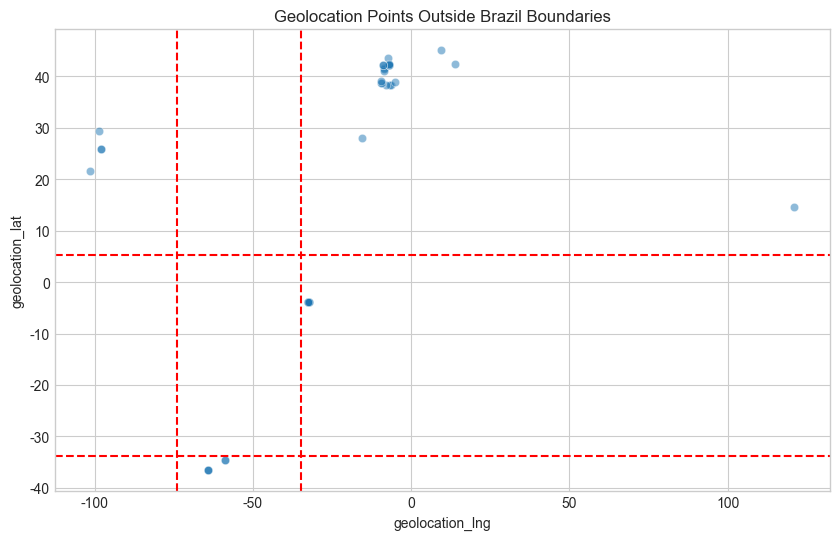

In [154]:
geolocation# 1. 브라질 경계 설정
lat_min, lat_max = -33.75, 5.27
lng_min, lng_max = -73.98, -34.79

# 2. 범위를 벗어나는 데이터 필터링
outside_brazil = geolocation[
    (geolocation['geolocation_lat'] > lat_max) | 
    (geolocation['geolocation_lat'] < lat_min) | 
    (geolocation['geolocation_lng'] > lng_max) | 
    (geolocation['geolocation_lng'] < lng_min)
]

print(f"🚩 브라질 외부로 추정되는 좌표 데이터: {len(outside_brazil)}건")

# 3. 주요 이상치 데이터 확인
display(outside_brazil.head())

# 4. 시각화 (선택 사항: 이상치가 어디에 분포하는지 scatter plot으로 확인)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=outside_brazil, x='geolocation_lng', y='geolocation_lat', alpha=0.5)
plt.axvline(lng_min, color='red', linestyle='--')
plt.axvline(lng_max, color='red', linestyle='--')
plt.axhline(lat_min, color='red', linestyle='--')
plt.axhline(lat_max, color='red', linestyle='--')
plt.title('Geolocation Points Outside Brazil Boundaries')
plt.show()

## 전처리된 테이블 저장

In [159]:
data_list = [clean_order_customers, clean_order_items, clean_order_paymets, clean_order_reviews, clean_orders, clean_products, clean_sellers, geolocation]
len(data_list)

8

In [160]:
import os

# 1. 경로 설정
raw_dir = '../data/raw/'
processed_dir = '../data/processed/'

# 폴더가 없으면 생성
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# 2. 데이터프레임 리스트 (노트북 L1-L2 기준)
# data_list = [clean_order_customers, clean_order_items, clean_order_paymets, 
#              clean_order_reviews, clean_orders, clean_products, clean_sellers, geolocation]

# 3. 원본 파일명 리스트 (data/raw 내 파일 순서와 매칭)
# olist 데이터셋의 표준 파일명을 기반으로 작성되었습니다.
file_names = [
    'olist_customers_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'olist_geolocation_dataset.csv'
]

# 4. 루프를 돌며 저장
for df, name in zip(data_list, file_names):
    # 파일명 앞에 clean_ 접두사 추가
    save_name = name
    save_path = os.path.join(processed_dir, save_name)
    
    # CSV 저장 (한글 깨짐 방지를 위해 utf-8-sig 사용)
    df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"Saved: {save_path}")

print("\n✅ 모든 데이터가 원본 파일명에 맞춰 저장되었습니다.")

Saved: ../data/processed/olist_customers_dataset.csv
Saved: ../data/processed/olist_order_items_dataset.csv
Saved: ../data/processed/olist_order_payments_dataset.csv
Saved: ../data/processed/olist_order_reviews_dataset.csv
Saved: ../data/processed/olist_orders_dataset.csv
Saved: ../data/processed/olist_products_dataset.csv
Saved: ../data/processed/olist_sellers_dataset.csv
Saved: ../data/processed/olist_geolocation_dataset.csv

✅ 모든 데이터가 원본 파일명에 맞춰 저장되었습니다.


In [ ]:
def perform_quality_check(table_name, df):
    """
    특정 테이블의 결측치, 기술통계, 이상치를 출력하는 함수
    """
    print(f"\n{'='*80}")
    print(f"🔍 ANALYSIS: [{table_name.upper()}] Table")
    print(f"{'='*80}")
    
    # 1. 결측치 (Missing Values)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)
    missing_df = pd.DataFrame({'Missing Count': missing, 'Ratio (%)': missing_pct})
    
    print("\n[1. 결측치 현황]")
    if missing.sum() > 0:
        display(missing_df[missing_df['Missing Count'] > 0])
    else:
        print("✅ 결측치 없음")
        
    # 2. 기술통계 (Descriptive Statistics)
    num_df = df.select_dtypes(include=[np.number])
    if not num_df.empty:
        print("\n[2. 수치형 데이터 기술통계]")
        display(num_df.describe().T)
        
        # 3. 이상치 시각화 (Boxplot)
        # 분석에 의미 있는 수치형 컬럼만 필터링 (ID, ZipCode 제외)
        plot_cols = [col for col in num_df.columns 
                     if 'zip' not in col.lower() and col != 'payment_sequential']
        
        if plot_cols:
            print(f"\n[3. 주요 컬럼 이상치 분석 - {table_name}]")
            n_cols = len(plot_cols)
            fig, axes = plt.subplots(1, n_cols, figsize=(max(4*n_cols, 12), 5))
            
            if n_cols == 1:
                sns.boxplot(y=df[plot_cols[0]], ax=axes, color='#FF9999')
                axes.set_title(plot_cols[0])
            else:
                for i, col in enumerate(plot_cols):
                    sns.boxplot(y=df[col].dropna(), ax=axes[i], color='#99FF99')
                    axes[i].set_title(col)
            
            plt.tight_layout()
            plt.show()
    else:
        print("\n[!] 수치형 컬럼이 존재하지 않습니다.")

# 모든 테이블에 대해 루프 실행
for name, df in tables.items():
    if df is not None:
        perform_quality_check(name, df)